Complete the following box to setup your configuration

In [1]:
from docplex.cp.model import *
context.solver.agent = 'local'
#context.solver.local.execfile = 'Path to the binary cpoptimizer' --> At INSA we use the following: 
context.solver.local.execfile = '/usr/local/insa/ibm_cplex_studio_2211/cpoptimizer/bin/x86-64_linux/cpoptimizer'
context.verbose = 0


#The solver's documentation is here 
#https://ibmdecisionoptimization.github.io/docplex-doc/cp/index.html

Please use the following parameters each time you call the solver 

In [2]:
myparams = CpoParameters(TimeLimit= 20,
                            LogVerbosity="Quiet" ,
                             SearchType = 'DepthFirst',
                             Presolve = 'Off',
                             Workers=  1,
                             RandomSeed = 2)

You can add as many cells as you want. Make sure to choose "Markdown" instead of "code" if you want to write in a natural language. 

When submitting your work, please re-execute the notebook from the start and do not remove the output. 

We want to set up a speed interview event between $n$ students and $n$ companies. Each student has a unique list that reflects his preferences towards companies. The first element is the most prefered company, the second one is the second most prefered, etc. For instance, if Alice's list of preferences is [4,1,3,2]. Then she prefers to be assigned to  company 4, then 1, then 3, then 2. Similarly, each company has a list of preferences towards students. The preferences represent a strict order (i.e., no ties). 

A matching $M$ is a one-to-one mapping from students to companies. Let $s$ be a student and $c$ be a company. The pair $(s,c)$ is unhappy in $M$ if they prefer to be together compared to their situation in $M$. That is, if $M[s] =c' $ and $ s' = M^{-1}[c]$ then $s$ prefers c than $c'$, and $c$ prefers $s$ than $s'$. 


The stable interview problem is the problem of finding a matching that has no unhappy pair. 

# Example 

The following code generates a random list of preferences

In [3]:
import numpy as np
import random

#Run The model 
# Example data
def generate_random_list(n) : 
    my_list = [i for i in range (n)]
    return random.sample(my_list, len(my_list))

To generate a random instance of the speed interview problem, we use the following function 

In [4]:
#Gererate an instance of size $6$
def generate_random_instance(n) : 

    s = [generate_random_list(n) for i in range(n)]
    c = [generate_random_list(n) for i in range(n)]
    return s, c


Generate a random instance of size 4

In [5]:
#Example with n= 4
n=10
students_preferences, companies_preferences = generate_random_instance(n)

print("\nstudents_preferences:")
print(np.matrix(students_preferences))

print("\ncompanies_preferences Preferences:")
print(np.matrix(companies_preferences))



students_preferences:
[[9 5 4 6 3 2 0 1 8 7]
 [7 3 5 8 4 6 1 0 9 2]
 [1 6 9 7 3 5 8 2 4 0]
 [0 1 2 4 7 8 5 6 9 3]
 [3 8 1 7 4 0 6 9 2 5]
 [8 3 2 4 1 0 7 6 9 5]
 [6 1 0 5 9 4 3 2 7 8]
 [4 9 3 7 0 5 2 6 1 8]
 [6 0 4 9 3 1 7 2 8 5]
 [0 1 8 5 2 7 6 4 3 9]]

companies_preferences Preferences:
[[5 6 0 7 2 9 1 3 8 4]
 [8 6 1 5 0 7 4 9 3 2]
 [9 4 5 7 1 3 2 6 0 8]
 [9 7 1 6 8 4 2 3 0 5]
 [0 7 3 5 1 4 6 9 2 8]
 [9 6 1 0 3 4 2 8 5 7]
 [9 7 8 5 6 1 2 3 0 4]
 [1 2 5 8 6 0 9 3 7 4]
 [7 2 1 6 8 3 0 4 5 9]
 [9 5 4 2 1 7 8 3 6 0]]




Complete the following function to model the stable interview problem. Do not call the solver to search for solutions in this function. We will do it saperately later. 


You can use the element expression if you want (but it is not mandatory) :  https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html?highlight=element#docplex.cp.modeler.element

In [6]:
from docplex.cp.model import *

def stable_interview(n, students_preferences, companies_preferences):
    mdl = CpoModel(name='stable_interview')

    # Create the variables
    M = mdl.integer_var_list(n, 0, n - 1, "M")
    

    # Create the constraints
    mdl.add(mdl.all_diff(M))

    def isHappy(n1, n2) :
        s1, c1 = n1
        s2, c2 = n2

        constraint1 = c1 in students_preferences[s1][:students_preferences[s1].index(c2)]
        constraint3 = c2 in students_preferences[s2][:students_preferences[s2].index(c1)]
        constraint2 = s1 in companies_preferences[c1][:companies_preferences[c1].index(s2)]
        constraint4 = s2 in companies_preferences[c2][:companies_preferences[c2].index(s1)]
        return not (constraint1 & constraint2 )

    for student1 in range(n) :
        for student2 in range(n) :
            for entreprise1 in range(n) :
                for entreprise2 in range(n) :
                    if student1!= student2 and entreprise1!= entreprise2 :
                        if not isHappy((student1, entreprise1), (student2, entreprise2)) :
                            mdl.add(mdl.logical_or(
                            mdl.element(M, student1) != entreprise2,
                            mdl.element(M, student2) != entreprise1
                        ))



    return mdl, M




Test your function on an instance of size n= 10. Ask the solver to generate only one solution

In [7]:
n = 10
students_preferences, companies_preferences = generate_random_instance(n)
mdl, _ = stable_interview(n, students_preferences, companies_preferences)
sol = mdl.solve()
sol.print_solution()
print(students_preferences, '\n', companies_preferences)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 10 variables, 1959 constraints


 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 33.2 (before), 33.2 (after)
 !  . Memory usage      : 627.9 kB (before), 627.9 kB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                     16  0.02s        1         5 != M_8
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 263
 ! Number of fails        : 116
 ! Total memory usage     : 9.8 MB (9.8 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent in solve    : 0.02s (0.01s engine + 0.02s extraction)
 ! Search speed (br. / s) : 26300.0
 ! ----------------------------------------------------------------------------
------------------------------------------------

How many decisions are made ? 

In [8]:
print("Il y a eu ", sol.get_solver_infos()['NumberOfChoicePoints'], "décisions")

Il y a eu  147 décisions


How many failures are made ? 

In [9]:
print('Il y a eu ', sol.get_solver_infos()['NumberOfFails'], 'échecs')

Il y a eu  116 échecs


What is the runtime ? 

In [10]:
print("Total runtime = ", sol.get_solver_infos()['TotalTime'], "ms")

Total runtime =  0.02 ms


Without changing your model, did you use an implied constraint? if yes, which one ? If no, can you find one (again without modifying the model) ? 

In [11]:
#Via le all diff, on a des contraintes implicites disant qu'une entreprise ne peut pas être attribué à plus d'un étudiant.

We want to setup a user-friendly solution printer. Let $CompanyOf[s]$ be the company to which student $s$ is matched. Similarly, we denote by $StudentOf[c]$ the student assigned to company $c$. 


Solve again the problem for n= 10, construct the lists $CompanyOf$ and  $StudentOf$, then print them. 

In [12]:
def solution(M) :
    CompanyOf = M 
    StudentOf = [M.index(i) for i in range(n)]

    return StudentOf, CompanyOf

M = [sol.get_var_solution(f'M_{i}').get_value() for i in range(n)]

StudentOf, CompanyOf = solution(M)
print('StudentOf : ', StudentOf, '\n CompanyOf :', CompanyOf)

StudentOf :  [4, 5, 0, 3, 6, 1, 7, 2, 8, 9] 
 CompanyOf : [2, 5, 7, 3, 0, 1, 4, 6, 8, 9]


We want to automate the experiments. Complete the following function that takes as input n, generates a new random instance, solve it, then returns the search status, the number of decisions, the number of failures, and the runtime

In [13]:
def run_decision_version(n) : 
    
    students_preferences, companies_preferences = generate_random_instance(n)
    mdl, _ = stable_interview(n, students_preferences, companies_preferences)
    sol = mdl.solve()
    nb_decisions = sol.get_solver_infos()['NumberOfChoicePoints']
    nb_failures = sol.get_solver_infos()['NumberOfFails']
    status = sol.get_solve_status()
    runtime = sol.get_solver_infos()['TotalTime']

    return status, nb_decisions, nb_failures, runtime

Test your function with a random instance. Print the status, the number of decisions, the number of failures, and the runtime

In [14]:
def print_speed_dating(n) :
    status, nb_decisions, nb_failures, runtime = run_decision_version(n)
    print('Status : ', status)
    print('Number of decisions : ', nb_decisions)
    print('Number of failures : ', nb_failures)
    print('Runtime : ', runtime)

Test the run function with four different sizes


In [15]:
print_speed_dating(10)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 10 variables, 1921 constraints
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 33.2 (before), 33.2 (after)
 !  . Memory usage      : 627.9 kB (before), 627.9 kB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                     80  0.02s        1         5  = M_2
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 227
 ! Number of fails        : 99
 ! Total memory usage     : 9.8 MB (9.7 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent in solve    : 0.02s (0.02s engine + 0.00s extraction)
 ! Search speed (br. / s) 

In [16]:
print_speed_dating(15)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 15 variables, 11432 constraints
 ! Initial process time : 0.06s (0.06s extraction + 0.00s propagation)
 !  . Log search space  : 58.6 (before), 58.6 (after)
 !  . Memory usage      : 2.2 MB (before), 2.2 MB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                    109  0.10s        1         4  = M_11
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 545
 ! Number of fails        : 247
 ! Total memory usage     : 37.9 MB (37.8 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent in solve    : 0.10s (0.04s engine + 0.06s extraction)
 ! Search speed (br. / s)

In [17]:
print_speed_dating(5)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 5 variables, 97 constraints
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.6 (before), 11.6 (after)
 !  . Memory usage      : 299.1 kB (before), 299.1 kB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                      7  0.02s        1         0  = M_0
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 53
 ! Number of fails        : 15
 ! Total memory usage     : 3.4 MB (3.3 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent in solve    : 0.02s (0.02s engine + 0.00s extraction)
 ! Search speed (br. / s) : 53

In [18]:
print_speed_dating(20)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 20 variables, 35374 constraints
 ! Initial process time : 0.25s (0.25s extraction + 0.00s propagation)
 !  . Log search space  : 86.4 (before), 86.4 (after)
 !  . Memory usage      : 6.1 MB (before), 6.1 MB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                    300  0.43s        1        11  = M_3
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 9254
 ! Number of fails        : 4579
 ! Total memory usage     : 115.6 MB (115.6 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent in solve    : 0.48s (0.24s engine + 0.25s extraction)
 ! Search speed (br. /

Find 10 different numbers $n_1 > n_2, \ldots > n_{10}$ such that the solver needs between $10$s to $20$s to find a solution for each size

In [19]:
b = True
n =36
while b :
    _,_,_,runtime= run_decision_version(n)
    if runtime > 10 and runtime < 20 :
        b = False
    n = n+1
    print(n)
    print('runtime : ', runtime)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 36 variables, 392635 constraints
 ! Initial process time : 3.11s (3.11s extraction + 0.00s propagation)
 !  . Log search space  : 186.1 (before), 186.1 (after)
 !  . Memory usage      : 65.3 MB (before), 65.3 MB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
                     1000         10    1         5 != M_4
                     1000         18    2   F     9  = M_22
                     1000         10    3   F    13  = M_21
                     1000         16    4         9 != M_17
                     1000         11    5   F    27  = M_12
                     1000         20    6   F    16  = M_19
                     2000          8    6   F    12 != M_5
 *                   1725  5.83s        5         5  = M_20
 ! ------

Choose two completely different search strategies, then run them on a random instance

In [20]:
def run_2_strategies(n, SearchType='DepthFirst'):
    
    students_preferences, companies_preferences = generate_random_instance(n)

    mdl1, M1 = stable_interview(n, students_preferences, companies_preferences)
    SearchPhase1 = mdl1.search_phase(M1, 
                                        varchooser=mdl1.select_smallest(mdl1.var_index(M1)),
                                        valuechooser=mdl1.select_smallest(mdl1.value_index(np.arange(n))))
    mdl1.add(SearchPhase1)
    sol_1 = mdl1.solve(SearchType=SearchType,  DefaultInferenceLevel="Medium")


    mdl2, M2 = stable_interview(n, students_preferences, companies_preferences)

    SearchPhase2 = mdl2.search_phase(M2, 
                                        varchooser=mdl2.select_smallest(mdl2.var_impact()),
                                        valuechooser=mdl2.select_random_value())
    mdl2.add(SearchPhase2)
    sol_2 = mdl2.solve(SearchType=SearchType,  DefaultInferenceLevel="Medium")
    return sol_1, sol_2

run_2_strategies(10)


 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 10 variables, 1996 constraints, 1 phase
 ! DefaultInferenceLevel = Medium
 ! SearchType           = DepthFirst
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 33.2 (before), 33.2 (after)
 !  . Memory usage      : 627.9 kB (before), 627.9 kB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                    102  0.02s        1         4 != M_3
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 612
 ! Number of fails        : 300
 ! Total memory usage     : 9.0 MB (9.0 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent

(<docplex.cp.solution.CpoSolveResult at 0x7f1032e0acc0>,
 <docplex.cp.solution.CpoSolveResult at 0x7f1032e0ae40>)

Run an experimental study to compare the two search strategies in terms of number of decisions and runtime on 20 instances of different sizes of your choice. We expect to have a visual comparision in the form of plots

In [21]:
runtime1, runtime2 = [],[]
numberofchoice1, numberofchoice2 = [],[]
n_settings = np.arange(5,25,1)

for n in n_settings:
    sol_1,sol_2 = run_2_strategies(n,'DepthFirst')
    sol_1,sol_2 = run_2_strategies(n,'DepthFirst')
    
    runtime1.append(sol_1.get_solver_infos()['TotalTime'])
    numberofchoice1.append(sol_1.get_solver_infos()['NumberOfChoicePoints'])
    runtime2.append(sol_2.get_solver_infos()['TotalTime'])
    numberofchoice2.append(sol_2.get_solver_infos()['NumberOfChoicePoints'])

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 5 variables, 98 constraints, 1 phase
 ! DefaultInferenceLevel = Medium
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.6 (before), 11.6 (after)
 !  . Memory usage      : 299.1 kB (before), 299.1 kB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                     17  0.02s        1         0 != M_3
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 102
 ! Number of fails        : 48
 ! Total memory usage     : 2.6 MB (2.6 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent in 

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 5 variables, 98 constraints, 1 phase
 ! DefaultInferenceLevel = Medium
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.6 (before), 11.6 (after)
 !  . Memory usage      : 299.1 kB (before), 299.1 kB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed    W       Branch decision
 *                      3  0.02s        1         2  = M_3
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 63
 ! Number of fails        : 26
 ! Total memory usage     : 2.7 MB (2.6 MB CP Optimizer + 0.0 MB Concert)
 ! Time spent in s

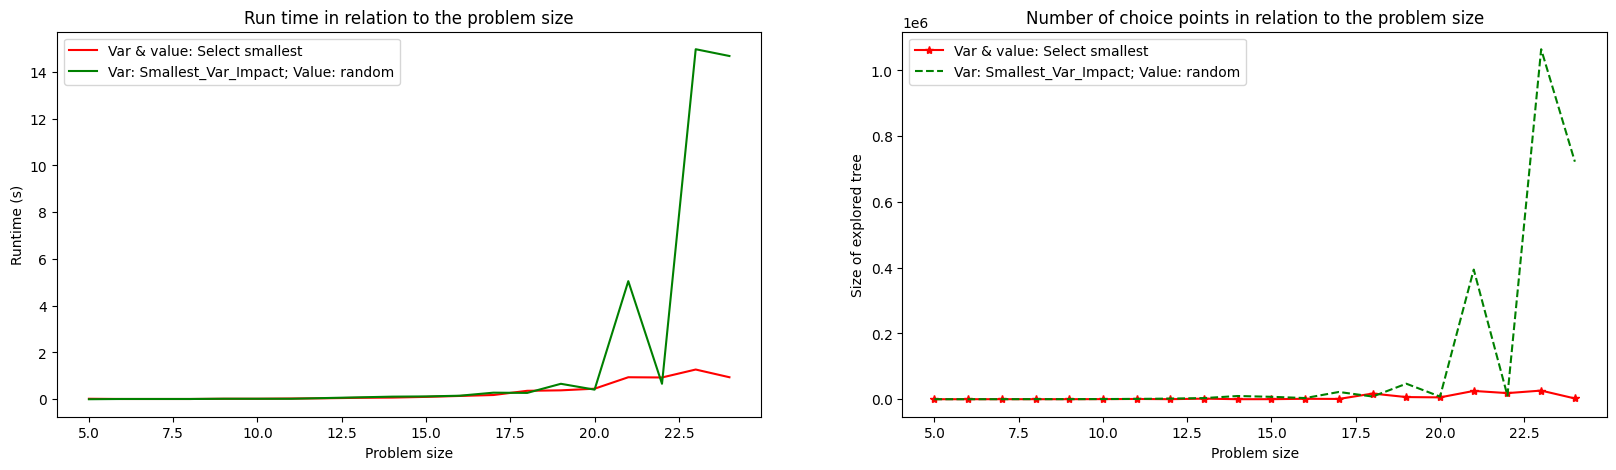

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(n_settings,runtime1,'r',label='Var & value: Select smallest')
plt.plot(n_settings,runtime2,'g',label='Var: Smallest_Var_Impact; Value: random')
plt.xlabel("Problem size")
plt.ylabel("Runtime (s)")
plt.legend(loc='best')
plt.title("Run time in relation to the problem size")

plt.subplot(122)
plt.plot(n_settings,numberofchoice1,'r*-',label='Var & value: Select smallest')
plt.plot(n_settings,numberofchoice2,'g--',label='Var: Smallest_Var_Impact; Value: random')
plt.xlabel("Problem size")
plt.ylabel("Size of explored tree")
plt.title("Number of choice points in relation to the problem size")
plt.legend(loc='best')


plt.show()

We want to give more previlage to students. Let $M$ be a solution and let $Index[s]$ be the index of $M[s]$ in the preference list of $s$. We want to minimize the maximum value of $\{Index[1], \ldots Index[N] \}$. Complete the following function to model for this optimisation problem. 

In [23]:
def optimal_stable_interview (n, students_preferences, companies_preferences):


    mdl, M = stable_interview(n, students_preferences, companies_preferences)

    Index = mdl.integer_var_list(n, 0, n - 1, "Index")


    for i in range(n) :
        Index[i] = mdl.sum(j * mdl.element(M, i) == students_preferences[i][j] for j in range(n))




    mdl.add(mdl.minimize(mdl.sum(Index)))

    return mdl


Test your model

In [24]:
n = 10
students_preferences, companies_preferences = generate_random_instance(n)
mdl = optimal_stable_interview(n, students_preferences, companies_preferences)
sol = mdl.solve()
sol.print_solution()
print(students_preferences, '\n', companies_preferences)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 10 variables, 2024 constraints
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 33.2 (before), 33.2 (after)
 !  . Memory usage      : 743.7 kB (before), 743.7 kB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         10                 -
 + New bound is 2
                       56          6    1   F     8 != M_2
 + New bound is 3
 *             6      155  0.04s        1      (gap is 50.00%)
               6      991          3    1            -
 + New bound is 6 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 6 (optimal - effective tol. is 0)
 ! Best b

In [25]:
n = 30
students_preferences, companies_preferences = generate_random_instance(n)
mdl = optimal_stable_interview(n, students_preferences, companies_preferences)
sol = mdl.solve()
sol.print_solution()
print(students_preferences, '\n', companies_preferences)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 30 variables, 191550 constraints
 ! Initial process time : 1.58s (1.58s extraction + 0.01s propagation)
 !  . Log search space  : 147.2 (before), 147.2 (after)
 !  . Memory usage      : 39.3 MB (before), 39.3 MB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         30                 -
 + New bound is 0
                     1000         18    1   F    10  = M_7
                     1000         16    2   F    26  = M_14
                     1000          9    3   F    11  = M_17
                     1000         16    4         3 != M_7
                     1000         12    5        27 != M_20
                     1000         15    6   F    13  = M_27
                     2000         14    1        22 != M_2

In [26]:
n = 20
students_preferences, companies_preferences = generate_random_instance(n)
mdl = optimal_stable_interview(n, students_preferences, companies_preferences)
sol = mdl.solve()
sol.print_solution()
print(students_preferences, '\n', companies_preferences)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 20 variables, 35175 constraints
 ! Initial process time : 0.25s (0.25s extraction + 0.00s propagation)
 !  . Log search space  : 86.4 (before), 86.4 (after)
 !  . Memory usage      : 7.6 MB (before), 7.6 MB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         20                 -
 + New bound is 1
                      326         11    1   F    14 != M_0
 + New bound is 2
 *             9      801  0.56s        1      (gap is 77.78%)
               9     1000          8    1   F     7 != M_4
               9     1000          7    2   F     6  = M_3
               9     1000          3    3   F    11  = M_14
               9     1000          3    4   F    18  = M_8
               9     1000         11    5   